In [18]:
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

glueContext = GlueContext(SparkContext.getOrCreate())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
taxi_data = glueContext.create_dynamic_frame.from_catalog(database="reinvent19", table_name="canonical")
print("2018/2019 Taxi Data Count: ", taxi_data.count())
taxi_data.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2018/2019 Taxi Data Count:  452091107
root
|-- pickup_datetime: timestamp
|-- dropoff_datetime: timestamp
|-- pulocationid: long
|-- dolocationid: long
|-- type: string
|-- vendorid: string

The records in your input files should contain the following fields:

    start—A string with the format YYYY-MM-DD HH:MM:SS. The start timestamp can't contain time zone information.

    target—An array of floating-point values or integers that represent the time series. You can encode missing values as null literals, or as "NaN" strings in JSON, or as nan floating-point values in Parquet.

    dynamic_feat (optional)—An array of arrays of floating-point values or integers that represents the vector of custom feature time series (dynamic features). If you set this field, all records must have the same number of inner arrays (the same number of feature time series). In addition, each inner array must have the same length as the associated target value. Missing values are not supported in the features. For example, if target time series represents the demand of different products, an associated dynamic_feat might be a boolean time-series which indicates whether a promotion was applied (1) to the particular product or not (0):

    {"start": ..., "target": [1, 5, 10, 2], "dynamic_feat": [[0, 1, 1, 0]]}

    cat (optional)—An array of categorical features that can be used to encode the groups that the record belongs to. Categorical features must be encoded as a 0-based sequence of positive integers. For example, the categorical domain {R, G, B} can be encoded as {0, 1, 2}. All values from each categorical domain must be represented in the training dataset. That's because the DeepAR algorithm can forecast only for categories that have been observed during training. And, each categorical feature is embedded in a low-dimensional space whose dimensionality is controlled by the embedding_dimension hyperparameter. For more information, see DeepAR Hyperparameters.

If you use a JSON file, it must be in JSON Lines format. For example:

{"start": "2009-11-01 00:00:00", "target": [4.3, "NaN", 5.1, ...], "cat": [0, 1], "dynamic_feat": [[1.1, 1.2, 0.5, ...]]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [2, 3], "dynamic_feat": [[1.1, 2.05, ...]]}
{"start": "1999-01-30 00:00:00", "target": [2.0, 1.0], "cat": [1, 4], "dynamic_feat": [[1.3, 0.4]]}

In this example, each time series has two associated categorical features and one time series features. 

In [20]:
df = taxi_data.toDF().cache()
df.show(30, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------------+------------+------------+----+--------+
|pickup_datetime    |dropoff_datetime|pulocationid|dolocationid|type|vendorid|
+-------------------+----------------+------------+------------+----+--------+
|2018-01-30 21:15:34|null            |129         |null        |fhv |fhv     |
|2018-01-30 21:35:29|null            |112         |null        |fhv |fhv     |
|2018-01-30 21:16:34|null            |42          |null        |fhv |fhv     |
|2018-01-30 21:40:35|null            |131         |null        |fhv |fhv     |
|2018-01-30 21:49:59|null            |121         |null        |fhv |fhv     |
|2018-01-30 21:44:55|null            |235         |null        |fhv |fhv     |
|2018-01-30 21:51:30|null            |235         |null        |fhv |fhv     |
|2018-01-30 22:15:28|null            |208         |null        |fhv |fhv     |
|2018-01-30 21:46:49|null            |265         |null        |fhv |fhv     |
|2018-01-30 21:35:23|null            |29          |n

In [21]:
from pyspark.sql.functions import to_date, lit
from pyspark.sql.types import TimestampType

dates = ("2018-01-01",  "2019-07-01")
date_from, date_to = [to_date(lit(s)).cast(TimestampType()) for s in dates]

df  = df.where((df.pickup_datetime > date_from) & (df.pickup_datetime < date_to))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We need to restructure this so that each time is a single row, and the time series values are in the series, followed by the numerical and categorical features


## Let's resample the data and get metrics over time.  Right now they are individual records down to the second level. 

In [22]:
from pyspark.sql.functions import col, max as max_, min as min_

## day = seconds*minutes*hours
unit = 60 * 60 * 24
epoch = (col("pickup_datetime").cast("bigint") / unit).cast("bigint") * unit

with_epoch = df.withColumn("epoch", epoch)

min_epoch, max_epoch = with_epoch.select(min_("epoch"), max_("epoch")).first()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# Reference range 
ref = spark.range(
    min_epoch, max_epoch + 1, unit
).toDF("epoch")

resampled_df = (ref
    .join(with_epoch, "epoch", "left")
    .orderBy("epoch")
    .withColumn("ts_resampled", col("epoch").cast("timestamp")))

resampled_df.cache()

resampled_df.show(10, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-------------------+----------------+------------+------------+----+--------+-------------------+
|epoch     |pickup_datetime    |dropoff_datetime|pulocationid|dolocationid|type|vendorid|ts_resampled       |
+----------+-------------------+----------------+------------+------------+----+--------+-------------------+
|1514764800|2018-01-01 09:20:00|null            |null        |null        |fhv |fhv     |2018-01-01 00:00:00|
|1514764800|2018-01-01 10:20:00|null            |null        |null        |fhv |fhv     |2018-01-01 00:00:00|
|1514764800|2018-01-01 11:20:00|null            |null        |null        |fhv |fhv     |2018-01-01 00:00:00|
|1514764800|2018-01-01 11:55:00|null            |null        |null        |fhv |fhv     |2018-01-01 00:00:00|
|1514764800|2018-01-01 14:15:00|null            |null        |null        |fhv |fhv     |2018-01-01 00:00:00|
|1514764800|2018-01-01 09:05:00|null            |null        |null        |fhv |fhv     |2018-01-01 00:00:00|
|151476480

You can see now that we are resampling per day the resample column, in which we can now aggregate across.

In [24]:
from pyspark.sql import functions as func
#count_per_day_resamples = resampled_df.groupBy(["ts_resampled", "type", "pulocationid", "dolocationid"]).count()
count_per_day_resamples = resampled_df.groupBy(["ts_resampled", "type"]).count()
count_per_day_resamples.cache()
count_per_day_resamples.show(10, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------+------+
|ts_resampled       |type  |count |
+-------------------+------+------+
|2018-03-05 00:00:00|yellow|290631|
|2018-11-11 00:00:00|yellow|257698|
|2018-11-20 00:00:00|yellow|278900|
|2018-03-15 00:00:00|yellow|348198|
|2018-12-30 00:00:00|fhv   |688807|
|2018-09-03 00:00:00|yellow|189402|
|2019-02-22 00:00:00|fhv   |65041 |
|2018-02-21 00:00:00|green |25651 |
|2019-03-07 00:00:00|yellow|291098|
|2018-11-28 00:00:00|green |22899 |
+-------------------+------+------+
only showing top 10 rows

## TODO -- Right now the "null" column is showing up instead of the fhvhv.  

In [25]:
#time_series_df = count_per_day_resamples.groupBy(["ts_resampled", "pulocationid", "dolocationid"])\
time_series_df = count_per_day_resamples.groupBy(["ts_resampled"])\
.pivot('type').sum("count").drop("null").cache()
time_series_df.show(30,False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------+-----+------+
|ts_resampled       |fhv   |green|yellow|
+-------------------+------+-----+------+
|2019-06-18 00:00:00|69383 |15545|242304|
|2018-09-09 00:00:00|803042|20365|256918|
|2019-03-21 00:00:00|47855 |20326|274057|
|2018-12-13 00:00:00|818550|24585|308411|
|2018-08-16 00:00:00|715263|22113|277677|
|2018-01-31 00:00:00|642437|26667|319256|
|2018-05-15 00:00:00|688946|25458|309023|
|2018-03-21 00:00:00|511349|11981|183629|
|2018-07-13 00:00:00|749636|24518|277145|
|2018-12-24 00:00:00|639463|19314|185895|
|2018-09-20 00:00:00|719646|23378|298630|
|2018-03-25 00:00:00|714282|25115|275756|
|2018-11-21 00:00:00|749954|22711|260399|
|2019-05-03 00:00:00|71081 |18265|275523|
|2018-07-27 00:00:00|809908|24765|281050|
|2018-02-13 00:00:00|639229|25869|317963|
|2019-05-12 00:00:00|57573 |14959|225371|
|2018-05-11 00:00:00|743644|29137|324657|
|2019-04-25 00:00:00|64567 |16580|266326|
|2018-10-19 00:00:00|806788|25717|304569|
|2018-09-25 00:00:00|701224|21278|

In [26]:
time_series_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

546

## now that we have 8 million entries -- let's send this back to the local python

In [27]:
%%spark -o time_series_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## we are in the local panda/python environment now


In [28]:
%%local
time_series_df.dtypes

ts_resampled    datetime64[ns]
fhv                      int64
green                    int64
yellow                   int64
dtype: object

In [29]:
%%local
import pandas as pd
time_series_df = time_series_df.set_index('ts_resampled', drop=True)
time_series_df = time_series_df.sort_index()

In [30]:
%%local
prediction_length = 12
context_length = 12

n_weeks = 7
end_training = time_series_df.index[-n_weeks*prediction_length]
print('end training time', end_training)

time_series = []
for ts in time_series_df.columns:
    time_series.append(time_series_df[ts])
    
time_series_training = []
for ts in time_series_df.columns:
    time_series_training.append(time_series_df.loc[:end_training][ts])

end training time 2019-04-08 00:00:00


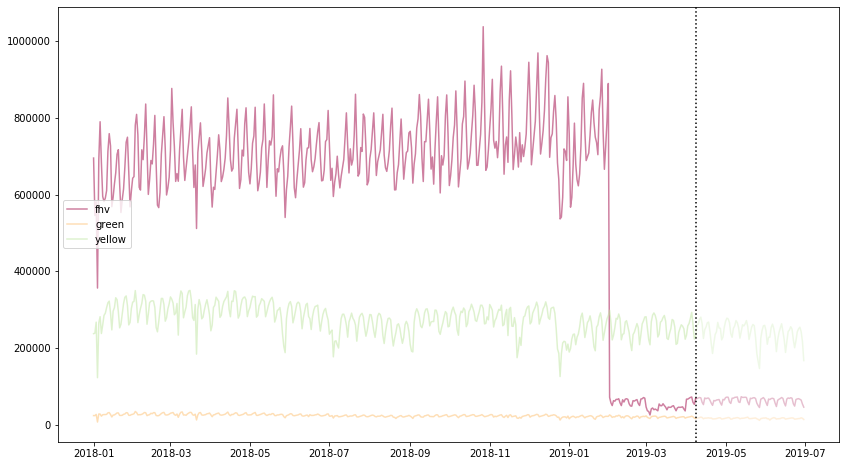

In [31]:
%%local
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#cols_float = time_series_df.drop(['pulocationid', 'dolocationid'], axis=1).columns
cols_float = time_series_df.columns
cmap = matplotlib.cm.get_cmap('Spectral')
colors = cmap(np.arange(0,len(cols_float))/len(cols_float))


plt.figure(figsize=[14,8]);
for c in range(len(cols_float)):
    plt.plot(time_series_df.loc[:end_training][cols_float[c]], alpha=0.5, color=colors[c], label=cols_float[c]);  
plt.legend(loc='center left');
for c in range(len(cols_float)):
    plt.plot(time_series_df.loc[end_training:][cols_float[c]], alpha=0.25, color=colors[c], label=None);
plt.axvline(x=end_training, color='k', linestyle=':');
#plt.text(time_series_df.index[int((time_series_df.shape[0]-n_weeks*prediction_length)*0.75)], time_series_df.max().max()/2, 'Train');
#plt.text(time_series_df.index[time_series_df.shape[0]-int(n_weeks*prediction_length/2)], time_series_df.max().max()/2, 'Test');
#plt.xlabel('Time');
#plt.show()

## we still need to pull in the FHV HV dataset starting in Feb

In [3]:
fhvhv_data = glueContext.create_dynamic_frame.from_catalog(database="2019reinventworkshop", table_name="fhvhv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
fhvhv_df = fhvhv_data.toDF().cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
from pyspark.sql.functions import to_date, lit
from pyspark.sql.types import TimestampType

dates = ("2018-01-01",  "2019-07-01")
date_from, date_to = [to_date(lit(s)).cast(TimestampType()) for s in dates]

fhvhv_df = fhvhv_df.where((fhvhv_df.pickup_datetime > date_from) & (fhvhv_df.pickup_datetime < date_to)).cache()
from pyspark.sql.functions import to_timestamp
fhvhv_df = fhvhv_df.withColumn("pickup_datetime", to_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
fhvhv_df.show(5, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|hvfhs_license_num|dispatching_base_num|pickup_datetime    |dropoff_datetime   |pulocationid|dolocationid|sr_flag|
+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|HV0003           |B02867              |2019-02-01 00:05:18|2019-02-01 00:14:57|245         |251         |null   |
|HV0003           |B02879              |2019-02-01 00:41:29|2019-02-01 00:49:39|216         |197         |null   |
|HV0005           |B02510              |2019-02-01 00:51:34|2019-02-01 01:28:29|261         |234         |null   |
|HV0005           |B02510              |2019-02-01 00:03:51|2019-02-01 00:07:16|87          |87          |null   |
|HV0005           |B02510              |2019-02-01 00:09:44|2019-02-01 00:39:56|87          |198         |null   |
+-----------------+--------------------+-------------------+-------------------+

In [7]:
fhvhv_df.dtypes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('hvfhs_license_num', 'string'), ('dispatching_base_num', 'string'), ('pickup_datetime', 'timestamp'), ('dropoff_datetime', 'string'), ('pulocationid', 'bigint'), ('dolocationid', 'bigint'), ('sr_flag', 'bigint')]

In [10]:
from pyspark.sql.functions import col, max as max_, min as min_

## day = seconds*minutes*hours
unit = 60 * 60 * 24

epoch = (col("pickup_datetime").cast("bigint") / unit).cast("bigint") * unit

with_epoch = fhvhv_df.withColumn("epoch", epoch)

min_epoch, max_epoch = with_epoch.select(min_("epoch"), max_("epoch")).first()

ref = spark.range(
    min_epoch, max_epoch + 1, unit
).toDF("epoch")

resampled_fhvhv_df = (ref
    .join(with_epoch, "epoch", "left")
    .orderBy("epoch")
    .withColumn("ts_resampled", col("epoch").cast("timestamp")))

resampled_fhvhv_df = resampled_fhvhv_df.cache()

resampled_fhvhv_df.show(10, False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+-------------------+
|epoch     |hvfhs_license_num|dispatching_base_num|pickup_datetime    |dropoff_datetime   |pulocationid|dolocationid|sr_flag|ts_resampled       |
+----------+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+-------------------+
|1548979200|HV0003           |B02867              |2019-02-01 00:05:18|2019-02-01 00:14:57|245         |251         |null   |2019-02-01 00:00:00|
|1548979200|HV0003           |B02879              |2019-02-01 00:41:29|2019-02-01 00:49:39|216         |197         |null   |2019-02-01 00:00:00|
|1548979200|HV0005           |B02510              |2019-02-01 00:51:34|2019-02-01 01:28:29|261         |234         |null   |2019-02-01 00:00:00|
|1548979200|HV0005           |B02510              |2019-02-01 00:03:51|2019-02-01 00:07:16|87          |87          |null   

In [13]:
from pyspark.sql import functions as func
#count_per_day_resamples = resampled_df.groupBy(["ts_resampled", "type", "pulocationid", "dolocationid"]).count()
count_per_day_resamples = resampled_fhvhv_df.groupBy(["ts_resampled"]).count()
count_per_day_resamples.cache()
count_per_day_resamples.show(10, False)
fhvhv_timeseries_df = count_per_day_resamples

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------+
|ts_resampled       |count |
+-------------------+------+
|2019-06-18 00:00:00|692171|
|2019-03-21 00:00:00|809819|
|2019-05-03 00:00:00|815626|
|2019-04-25 00:00:00|689853|
|2019-05-12 00:00:00|857727|
|2019-03-10 00:00:00|812902|
|2019-04-30 00:00:00|655312|
|2019-06-26 00:00:00|663954|
|2019-06-06 00:00:00|682378|
|2019-02-06 00:00:00|663516|
+-------------------+------+
only showing top 10 rows

In [14]:
%%spark -o fhvhv_timeseries_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%local
fhvhv_timeseries_df = fhvhv_timeseries_df.rename(columns={"count": "fhvhv"})
fhvhv_timeseries_df = fhvhv_timeseries_df.set_index('ts_resampled', drop=True)

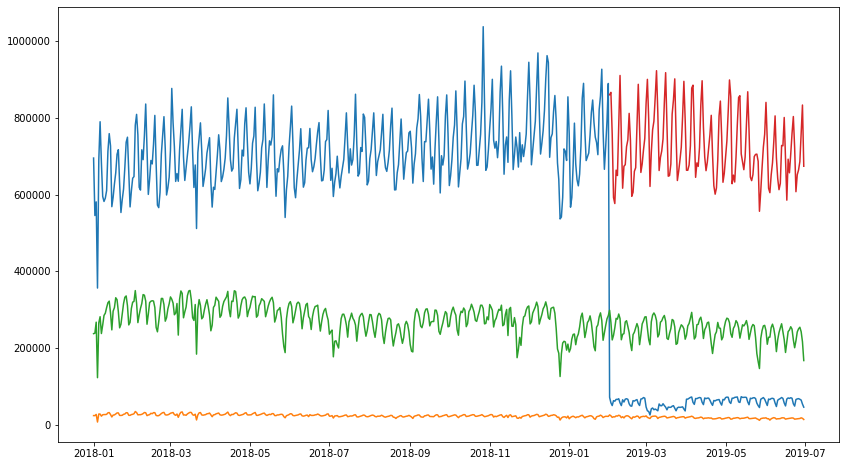

In [44]:
%%local
plt.figure(figsize=[14,8]);
plt.plot(time_series_df.join(fhvhv_timeseries_df))

In [58]:
%%local
full_timeseries = time_series_df.join(fhvhv_timeseries_df)
full_timeseries = full_timeseries.fillna(0)
full_timeseries['full_fhv'] = full_timeseries['fhv'] + full_timeseries['fhvhv']
full_timeseries = full_timeseries.drop(['fhv', 'fhvhv'], axis=1)

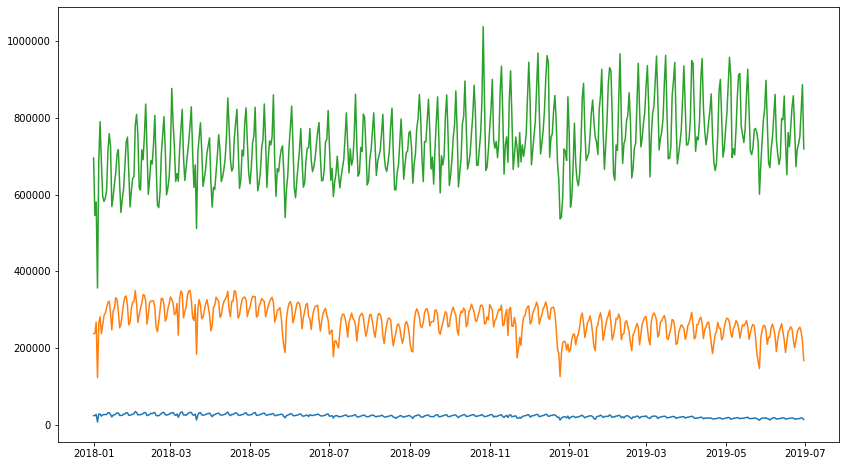

In [61]:
%%local
plt.figure(figsize=[14,8]);
plt.plot(full_timeseries)